In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
from extraction_bam_sif import *

In [3]:
gain=3.853           # gain [e-/ADU]
readnoise=8.365785291814616 # readout noise [e-]
bias=2576            # bias [ADU]

In [4]:
# let's process multiple files at once - I want some nicer statistic
# this is a time-ordered file of filenames

pathfile = "../filenames_bam-sif_new.txt"


allfiles = []
f = open(pathfile, 'r')
allfiles = f.readlines()
f.close()

# strip away newlines and add absolute path prefix
allfiles = ["../../"+s.strip() for s in allfiles]

# select sourcefiles for this run

sourcefiles = []


# some random date(s)
#mydates = ["2017-06-30","2017-07-01","2017-07-02","2017-07-03","2017-07-04","2017-07-05","2017-07-06"]
#mydates = ["2017-09-14"]

# get an entire month
#year = 2014   # 2017
#month = 5     # 6
#mydates = ["{}-{:02d}-{:02d}".format(year,month,day) for day in range(32)] # Feb 31 does not exist, but we don't care


#for date in mydates:
#    sourcefiles += [s for s in allfiles if date in s]

    
# heck, just get everything
sourcefiles = allfiles




#sourcefiles = [sourcefiles[1]]  # if I want to use only one file

print("Using", len(sourcefiles), "files")

Using 1484 files


In [5]:
from astropy.io import fits
from scipy.stats import trimboth

Alright, let's prototype something for this.

In [27]:
out0 = []
out1 = []

# time it
import time
tstart = time.time()

# loop over sourcefiles

for ii in range(len(sourcefiles)):
    source = fits.getdata(sourcefiles[ii])
    headerdat = fits.getheader(sourcefiles[ii])
    
    
    # Get the background

    # determine the background using outlier rejection
    unexposed = source[4401:4500,2:].astype("float64") # last pixels of the image area
    #unexposed = source[-99:,1:142].astype("float64")     # pixels outside image area
    # throw away highest and lowest 25%
    unexposed = trimboth(unexposed,0.25,axis=0) - bias

    sdevs = np.std(unexposed, axis=0)
    background = np.mean(unexposed, axis=0)

    background = np.rint(background).astype('uint16')


    # Extract cosmics from some region - bias should be subtracted
    
    N_AL = 720 # the standard
    #N_AL = 500 # for the other field -- still gets some stray light


    extracted = np.zeros((N_AL,160))
    extracted[:,:] = np.copy(source[-99-N_AL:-99,2:]) - bias
    # we should also be able to use the region 'before' the pattern, no?
    #extracted[:,:] = np.copy(source[:N_AL,2:]) - bias



    # signal and uncertainty

    signal = (extracted - background)*gain
    err_sig = np.sqrt(np.abs(extracted) + readnoise*readnoise + sdevs*sdevs) # this should be accurate?

    # we get two outputs - one per fov
    output_0 = bam_cosmics(signal[:,:80], err_sig[:,:80], 10, 0.5, 0, gain)
    #output_1 = bam_cosmics(signal[:,80:], err_sig[:,80:], 10, 0.5, 0, gain)
    output_1 = bam_cosmics(signal[:,80:140], err_sig[:,80:140], 10, 0.5, 0, gain) # to get rid of possible straylight
    
    # housekeeping: populate the headers
    output_0.row=1  # Careful if you ever take data from row 2
    output_0.fov=1
    output_0.gain=gain
    output_0.acqTime=headerdat["OBMT_BEG"]
    
    output_1.row=1  # Careful if you ever take data from row 2
    output_1.fov=2
    output_1.gain=gain
    output_1.acqTime=headerdat["OBMT_BEG"]
    

    out0.append(output_0)
    out1.append(output_1)

        
tend = time.time()
print("Elapsed time:", tend - tstart)

Elapsed time: 22.040924549102783


WOW, we can just do the entire thing at once...

# Some diagnostics

In [28]:
# This should be quite a lot of energies, so do a histogram

E0 = []
E1 = []

# also for lengths, why not
AL0 = []
AL1 = []
AC0 = []
AC1 = []

for ii in range(len(out0)):
    E0 += list(out0[ii].data["TRACK_EN"])
    AL0 += list(out0[ii].data["DIM_AL"]-1)
    AC0 += list(out0[ii].data["DIM_AC"]-1)
    E1 += list(out1[ii].data["TRACK_EN"])
    AL1 += list(out1[ii].data["DIM_AL"]-1)
    AC1 += list(out1[ii].data["DIM_AC"]-1)

E0 = np.array(E0)
E1 = np.array(E1)
AL0 = np.array(AL0)
AC0 = np.array(AC0)
AL1 = np.array(AL1)
AC1 = np.array(AC1)

        
# number of cosmics
print("FOV 0:", len(E0), "cosmics")
print("FOV 1:", len(E1), "cosmics")

FOV 0: 72023 cosmics
FOV 1: 54172 cosmics


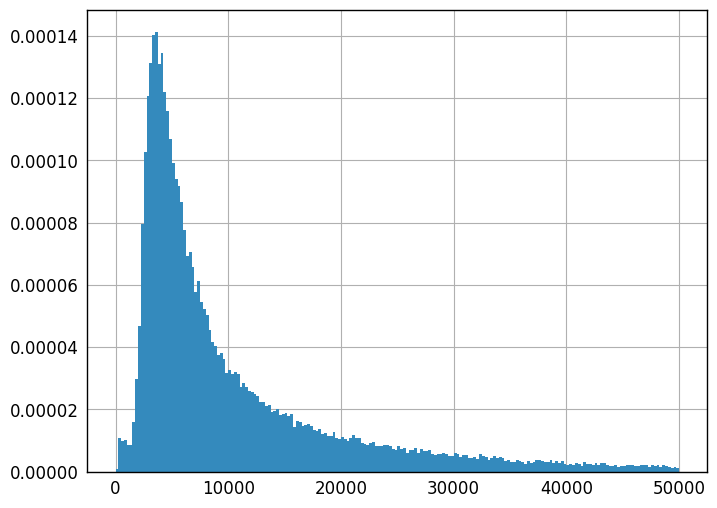

In [45]:
hist0 = plt.hist(E0, 200, log=False ,range=(0,50000), normed=True)

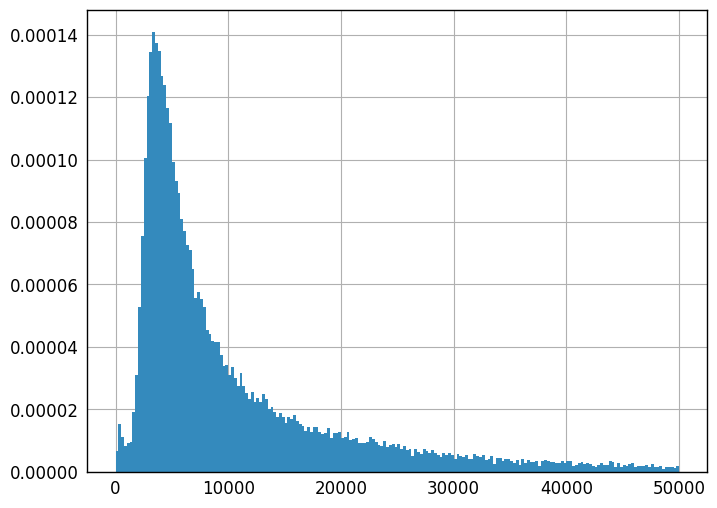

In [46]:
hist1 = plt.hist(E1, 200, log=False ,range=(0,50000), normed=True)

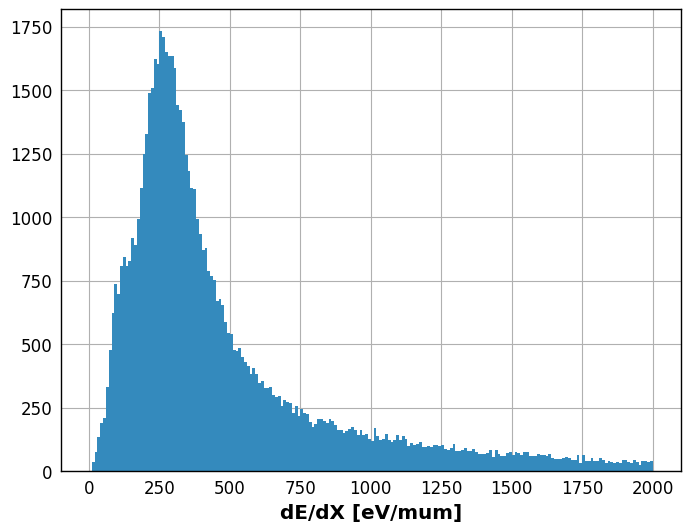

In [47]:
# Let's try dE/dx
lx = AL0*10  # mum
ly = AC0*120 # mum

lengths = np.sqrt(lx*lx + ly*ly)

dEdx = E0/np.sqrt(lengths**2+40**2) # assuming our length measurement is good and we go through the whole detector

dEdx *= 3.6   # energy (eV) per electron/hole pair

thist = plt.hist(dEdx,200,log=False,range=(0,2000))
plt.xlabel("dE/dX [eV/mum]")

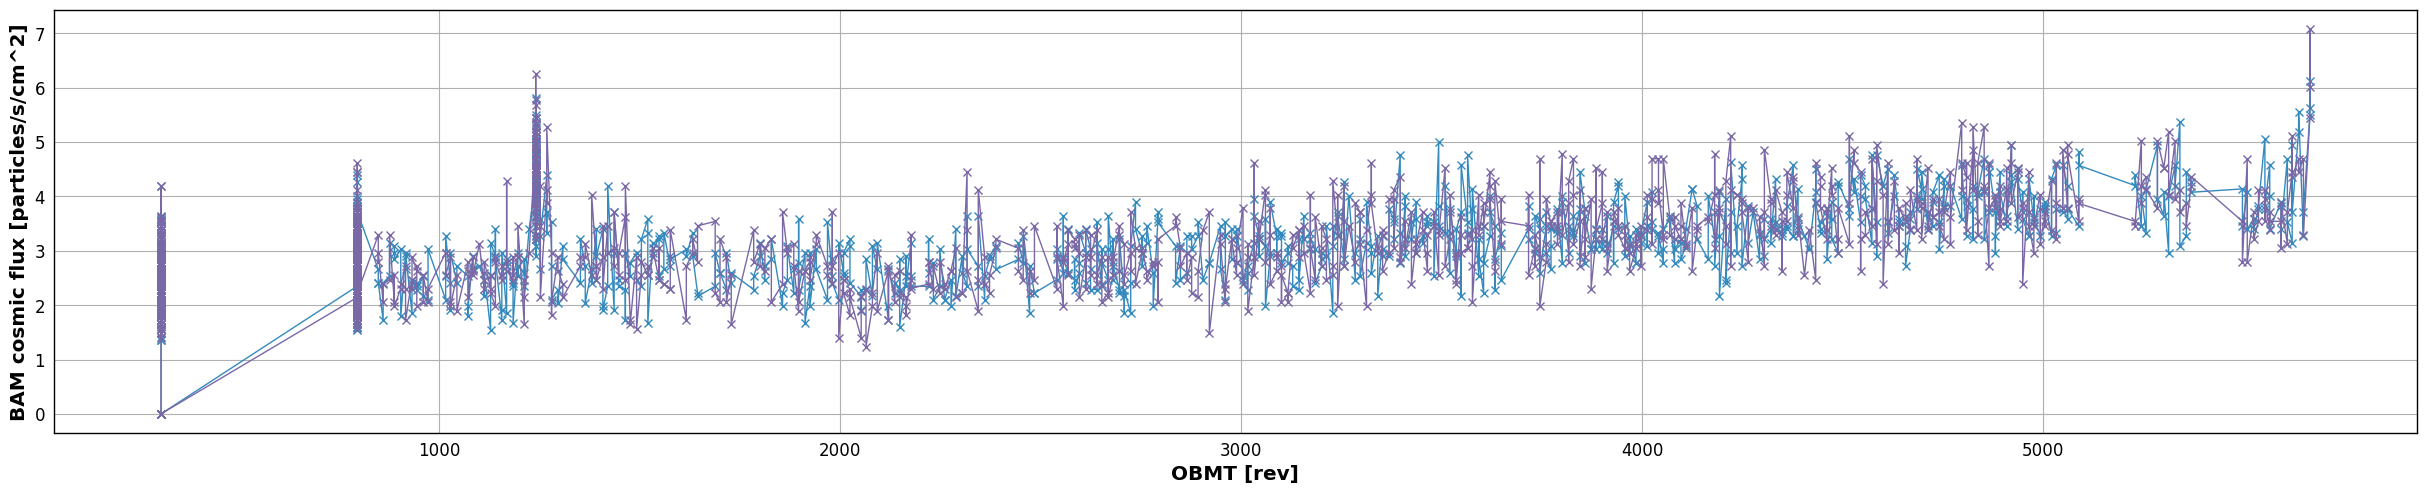

In [54]:
acqTimes = []

for ii in range(len(out0)):
    acqTimes.append(out0[ii].acqTime)
    
acqTimes = np.array(acqTimes)
acqTimes = acqTimes /1e9 / 3600/ 6  # roughly equals revs, no?
#acqTimes = acqTimes /1e9 / 3600/ 24/ 365  # years since start, basically
# both fov have the same acqTime



# fluxes
flux0 = [obs.calculate_flux() for obs in out0]
flux1 = [obs.calculate_flux() for obs in out1]

plt.plot(acqTimes,flux0,marker='x',linestyle='-')
plt.plot(acqTimes,flux1,marker='x',linestyle='-')
plt.xlabel("OBMT [rev]")
plt.ylabel("BAM cosmic flux [particles/s/cm^2]")
plt.gcf().set_size_inches(30.5, 5.5)

In [36]:
obs = out0[-1]

print(len(obs.data))

91


In [34]:
# for fun - make a cosmic ray image from a TrackObs

image = np.zeros((obs.srcAL,obs.srcAC))

for ii in range(len(obs.data)):
    track = np.reshape(obs.data[ii]["TRACK"], (obs.data[ii]["DIM_AL"],obs.data[ii]["DIM_AC"]))
    start_AL = obs.data[ii]["LOC_AL"]
    stop_AL = obs.data[ii]["LOC_AL"] + obs.data[ii]["DIM_AL"]
    start_AC = obs.data[ii]["LOC_AC"]
    stop_AC = obs.data[ii]["LOC_AC"] + obs.data[ii]["DIM_AC"]
    image[start_AL:stop_AL,start_AC:stop_AC] += track

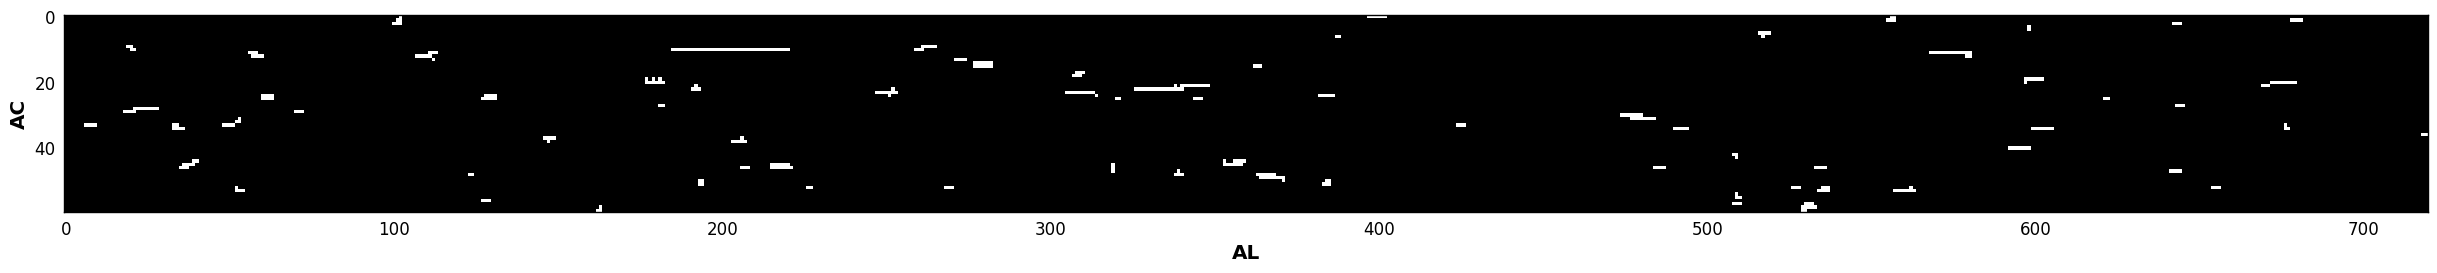

In [35]:
im=np.rot90(image,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(im, cmap='gray',vmax=20)#,aspect=12)
#plt.imshow(image[30:60,70:120], cmap='gray')
plt.gcf().set_size_inches(30.5, 5.5)
#plt.colorbar(orientation="horizontal")
plt.grid(False)

FOV 2 has some strange glitches towards the edge - probably the stray light that ralf talked about